# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data 


Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [164]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [165]:
data = pd.read_csv('train.csv')

In [166]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [167]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(data, test_size=0.3, random_state=42)
y_train = pd.DataFrame(X_train, columns=["target"])
y_test = pd.DataFrame(X_test, columns=["target"])

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [168]:
print(X_train.isna().sum())
print(X_test.isna().sum())

X_train = X_train.fillna("")
X_test = X_test.fillna("")

id             0
keyword       44
location    1760
text           0
target         0
dtype: int64
id            0
keyword      17
location    773
text          0
target        0
dtype: int64


## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?


In [169]:
class_counts = X_train["target"].value_counts()

print("Распределение классов в обучающей выборке:")
print(class_counts)

Распределение классов в обучающей выборке:
0    3024
1    2305
Name: target, dtype: int64


2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [170]:
popular_keywords = X_train["keyword"].value_counts().head(10).index.tolist()

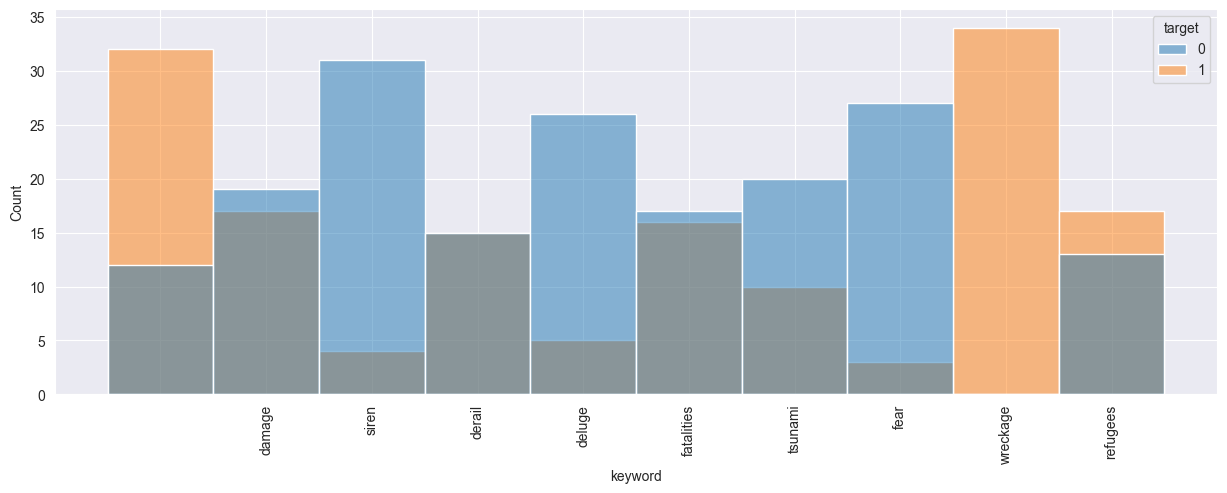

In [171]:
plt.figure(figsize=(15, 5))
sns.histplot(data=X_train[X_train["keyword"].isin(popular_keywords)], x='keyword', hue='target', multiple='layer', edgecolor='white', shrink=1)
plt.xticks(rotation=90)
plt.show()

**Выводы**: Если встречается wreckage, то сообщение содержит информацию о катастрофе. Damage/fatalities - 50/50. Сообщения с другими ключевыми словами с большей вероятностью не содержат информацию о катастрофе.

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [172]:
X_train.loc[[6590, 7122, 2769]]

,id,keyword,location,text,target
6590,9436,survivors,"Marietta, GA",Stemming from my #Cubs talk- the team rosters ...,1
7122,10203,violent%20storm,,If you were the NWS wth a rotating storm w/ a ...,1
2769,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


In [173]:
train_new = X_train.copy()
train_new["text"] = X_train["keyword"].fillna("") + " " + X_train["location"].fillna("") + " " + X_train["text"].fillna("")
train_new = train_new.drop(columns=["id", "keyword", "location"])

In [174]:
train_new.loc[[6590, 7122, 2769]]

,text,target
6590,"survivors Marietta, GA Stemming from my #Cubs ...",1
7122,violent%20storm If you were the NWS wth a rot...,1
2769,devastation Atlanta g.a. http://t.co/Gxgm1T3W0...,0


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [175]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

# Преобразуем текстовые данные в матрицу признаков
X_train_v = vectorizer.fit_transform(train_new["text"])

print("Размер матрицы признаков: ", X_train_v.shape)

Размер матрицы признаков:  (5329, 18455)


## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [176]:
from string import punctuation

def contains_digit(s: str) -> bool:
    return any(char.isdigit() for char in s)

def contains_punctuation(s: str) -> bool:
    return any(punctuation_char in s for punctuation_char in punctuation)

def is_hashtag(s: str) -> bool:
    return s.startswith("#")

def is_mention(s: str) -> bool:
    return s.startswith("@")

def investigate_vocabulary(vocabulary):
    words_with_digit = [word for word, frequency in vocabulary.items() if contains_digit(word)]
    words_with_punctuation = [word for (word, frequency) in vocabulary.items() if contains_punctuation(word)]
    words_with_hashtag = [word for word, frequency in vocabulary.items() if is_hashtag(word)]
    words_with_mentions = [word for word, frequency in vocabulary.items() if is_mention(word)]
    print('With digit:      ', len(words_with_digit)
          )
    print('With punctuation:', len(words_with_punctuation)
          )
    print('Hashtags:        ', len(words_with_hashtag)
          )
    print('Mentions:        ', len(words_with_mentions)
          )




In [177]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [178]:
investigate_vocabulary(vectorizer.vocabulary_)

With digit:       3812
With punctuation: 315
Hashtags:         0
Mentions:         0


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [179]:
from nltk.tokenize import TweetTokenizer
tt = TweetTokenizer()
vectorizer_tweet = CountVectorizer(tokenizer=tt.tokenize)
X_train_tt = vectorizer_tweet.fit_transform(train_new["text"])

/Users/h2o/Desktop/Code/Python/iad/ml_iad/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [180]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [181]:
investigate_vocabulary(vectorizer_tweet.vocabulary_)

With digit:       3939
With punctuation: 7338
Hashtags:         1470
Mentions:         1679


**Сравнение:** TweetTokenizer корректно разделяет слова в твитах, благодаря чему мы видим, что теперь мы корректно можем распознавать хэнтеги и меншэны, а также значительно больше пунктуации

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer



In [182]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

from string import ascii_lowercase

nltk.download('stopwords')

def contains_only_latin_letters(s: str) -> bool:
    return all(char in ascii_lowercase for char in s)

def is_emoji(s: str) -> bool:
    return all(char in punctuation for char in s) and ('(' in s or ')' in s)

def is_hashtag(s: str) -> bool:
    return s.startswith("#")

def custom_tokenizer(s: str) -> List[str]:    
    text = s.lower()

    tt = TweetTokenizer()
    tokens = tt.tokenize(text)

    tokens = [token for token in tokens if contains_only_latin_letters(token) or is_emoji(token) or (is_hashtag(token) and contains_only_latin_letters(token[1:]))]

    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]

    stemmer = SnowballStemmer("english")
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    return stemmed_tokens
  

[nltk_data] Downloading package stopwords to /Users/h2o/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [183]:
custom_tokenizer('She LOVES painting :-) #art')

['love', 'paint', ':-)', '#art']

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [184]:
for i, text in enumerate(train_new["text"].head(10)):
    print(f"{i + 1}. {custom_tokenizer(text)}")

1. ['bridg', 'ash', 'australia', 'collaps', 'trent', 'bridg', 'among', 'worst', 'histori', 'england', 'bundl', 'australia']
2. ['hail', 'carol', 'stream', 'illinoi', 'great', 'michigan', 'techniqu', 'camp', 'thank', '#goblu', '#wrestleon']
3. ['polic', 'houston', 'cnn', 'tennesse', 'movi', 'theater', 'shoot', 'suspect', 'kill', 'polic']
4. ['riot', 'still', 'riot', 'coupl', 'hour', 'left', 'class']
5. ['wound', 'lake', 'highland', 'crack', 'path', 'wipe', 'morn', 'beach', 'run', 'surfac', 'wound', 'left', 'elbow', 'right', 'knee']
6. ['airplan', 'somewher', 'expert', 'franc', 'begin', 'examin', 'airplan', 'debri', 'found', 'reunion', 'island', 'french', 'air', 'accid', 'expert', '#mlb']
7. ['bloodi', 'isol', 'citi', 'world', 'perth', 'came', 'kill', 'indian', 'fun', 'video', 'smirk', 'remorseless', 'pakistani', 'killer', 'show', 'boast']
8. ['burn', 'except', 'idk', 'realli', 'burn']
9. ['destroy', '(', 'ask', ')', 'destroy', 'hous']
10. ['wound', 'maracay', 'nirgua', 'venezuela', 'pol

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.


In [185]:
test_new = X_test.copy()
test_new["text"] = X_test['keyword'].fillna("") + " " + X_test["location"].fillna("") + " " + X_test["text"].fillna("")
test_new = test_new.drop(columns=["id", "keyword", "location"])

vectorizer = CountVectorizer(tokenizer=custom_tokenizer)
train_copy = train_new.copy()
test_copy = test_new.copy()

train_copy = train_copy.drop(columns=["target"])
test_copy = test_copy.drop(columns=["target"])

X_train_ct = vectorizer.fit_transform(train_copy["text"])
X_test_ct = vectorizer.transform(test_copy["text"])

/Users/h2o/Desktop/Code/Python/iad/ml_iad/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


2. Обучите LogisticRegression на полученных признаках.


In [186]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(X_train_ct, y_train)

/Users/h2o/Desktop/Code/Python/iad/ml_iad/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

3. Посчитайте метрику f1-score на тестовых данных.

In [187]:
from sklearn.metrics import f1_score

y_pred = lr.predict(X_test_ct)

f1 = f1_score(y_test, y_pred)

print(f"f1-score: {f1:.5f}")

f1-score: 0.75295


## Задание 9 (1 балл)

1. Повторите 8 задание, но с tf-idf векторизатором. Как изменилось качество?


In [188]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_tf = TfidfVectorizer(tokenizer=custom_tokenizer)

X_train_ctt = vectorizer_tf.fit_transform(train_copy["text"])
X_test_ctt = vectorizer_tf.transform(test_copy["text"])

lr_on_tf = LogisticRegression()

lr_on_tf.fit(X_train_ctt, y_train)

y_pred_tf = lr_on_tf.predict(X_test_ctt)

f1_tf = f1_score(y_test, y_pred_tf)

print(X_train_ctt.shape)
print(f"f1-score: {f1_tf:.5f}")

/Users/h2o/Desktop/Code/Python/iad/ml_iad/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(5329, 10482)
f1-score: 0.74222


/Users/h2o/Desktop/Code/Python/iad/ml_iad/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1. **Ответ:** Да ничего собственно не поменялось) Стало чуть-чуть хуже

2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [189]:
vectorizer_max_df = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9)

X_train_max_df = vectorizer_max_df.fit_transform(train_copy["text"])
X_test_max_df = vectorizer_max_df.transform(test_copy["text"])

lr_max_df = LogisticRegression()

lr_max_df.fit(X_train_max_df, y_train)

y_pred_max_df = lr_max_df.predict(X_test_max_df)

f1_max_df = f1_score(y_test, y_pred_max_df)

print(X_train_max_df.shape)
print(f"f1-score: {f1_max_df:.5f}")

/Users/h2o/Desktop/Code/Python/iad/ml_iad/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(5329, 10482)
f1-score: 0.74222


/Users/h2o/Desktop/Code/Python/iad/ml_iad/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2. **Ответ:** Как можем видеть, это не дало никаких абсолютно изменений)

3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [190]:
vectorizer_df_m = TfidfVectorizer(tokenizer=custom_tokenizer, min_df=0.001, max_df=0.9)

X_train_df_m = vectorizer_df_m.fit_transform(train_copy["text"])
X_test_df_m = vectorizer_df_m.transform(test_copy["text"])

lr_df_m = LogisticRegression()

lr_df_m.fit(X_train_df_m, y_train)

y_pred_df_m = lr_df_m.predict(X_test_df_m)

f1_df_m = f1_score(y_test, y_pred_df_m)

print(X_train_df_m.shape)
print(f"f1-score: {f1_df_m:.5f}")

/Users/h2o/Desktop/Code/Python/iad/ml_iad/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(5329, 1741)
f1-score: 0.74493


/Users/h2o/Desktop/Code/Python/iad/ml_iad/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


3. **Ответ:** Как можем видеть, размер матрицы уменьшился, но результат не сильно лучше.

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 8 с HashingVectorizer, укажите количество фичей равное 5000.


In [191]:
from sklearn.feature_extraction.text import HashingVectorizer

vectorizer_hv = HashingVectorizer(tokenizer=custom_tokenizer, n_features=5000)

X_train_hv = vectorizer_hv.fit_transform(train_copy["text"])
X_test_hv = vectorizer_hv.transform(test_copy["text"])

lr_hv = LogisticRegression()

lr_hv.fit(X_train_hv, y_train)

y_pred_hv = lr_hv.predict(X_test_hv)

f1_hv = f1_score(y_test, y_pred_hv)

print(X_train_hv.shape)
print(f"f1-score: {f1_hv:.5f}")

/Users/h2o/Desktop/Code/Python/iad/ml_iad/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(5329, 5000)
f1-score: 0.71906


/Users/h2o/Desktop/Code/Python/iad/ml_iad/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2. Какой из подходов показал самый высокий результат?

2. **Ответ:** Самый стандартный первый подход с CountVectorizer используя наш токенайзер оказался лучше))

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [192]:
vectorizer_st = CountVectorizer(tokenizer=custom_tokenizer)

X_train_st = vectorizer_st.fit_transform(train_copy["text"])
X_test_st = vectorizer_st.transform(test_copy["text"])

lr_st = LogisticRegression()

lr_st.fit(X_train_st, y_train)

y_pred_st = lr_st.predict(X_test_st)

f1_st = f1_score(y_test, y_pred_st)

print(X_train_st.shape)
print(f"f1-score: {f1_st:.5f}")

/Users/h2o/Desktop/Code/Python/iad/ml_iad/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(5329, 10482)
f1-score: 0.75295


/Users/h2o/Desktop/Code/Python/iad/ml_iad/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
